In [25]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import pandas as pd
import seaborn as sns
import numpy as np
from collections import defaultdict


In [26]:
def parse_metrics(file_path):
    epoch_pattern = re.compile(r"\|\s+Epoch\s+\|\s+(\d+)\s+\|")
    batch_time_pattern = re.compile(r"\|\s+Average Batch Time \(sec\)\s+\|\s+([\d\.]+)\s+\|")
    gpu_mem_pattern = re.compile(r"\|\s+Maximum GPU Memory Usage \(MB\)\s+\|\s+([\d\.]+)\s+\|")
    cpu_mem_pattern = re.compile(r"\|\s+Maximum CPU Memory Usage \(MB\)\s+\|\s+([\d\.]+)\s+\|")
    energy_pattern = re.compile(r"\|\s+Energy Consumption \(kWh\)\s+\|\s+([\d\.]+) kWh\s+\|")
    co2_pattern = re.compile(r"\|\s+CO₂ Emissions \(kg\)\s+\|\s+([\d\.]+) kg\s+\|")

    batch_times = []
    gpu_mems = []
    cpu_mems = []
    total_energy = 0.0
    total_co2 = 0.0
    last_valid_co2 = None

    with open(file_path, 'r') as f:
        content = f.read()

    blocks = content.split("+-------------------------------+------------+")
    for block in blocks:
        epoch_match = epoch_pattern.search(block)
        if epoch_match:
            batch_time_match = batch_time_pattern.search(block)
            gpu_mem_match = gpu_mem_pattern.search(block)
            cpu_mem_match = cpu_mem_pattern.search(block)
            energy_match = energy_pattern.search(block)
            co2_match = co2_pattern.search(block)

            if batch_time_match:
                batch_times.append(float(batch_time_match.group(1)))
            if gpu_mem_match:
                gpu_mems.append(float(gpu_mem_match.group(1)))
            if cpu_mem_match:
                cpu_mems.append(float(cpu_mem_match.group(1)))
            if energy_match:
                total_energy += float(energy_match.group(1))

            if co2_match:
                co2_str = co2_match.group(1)
                if "0.000" in co2_str and last_valid_co2 is not None:
                    co2_val = last_valid_co2
                else:
                    co2_val = float(co2_str)
                    last_valid_co2 = co2_val
                total_co2 += co2_val

    avg_batch_time = sum(batch_times) / len(batch_times) if batch_times else 0
    avg_gpu_mem = sum(gpu_mems) / len(gpu_mems) if gpu_mems else 0
    avg_cpu_mem = sum(cpu_mems) / len(cpu_mems) if cpu_mems else 0

    return {
        "Average Batch Time (sec)": avg_batch_time,
        "Average GPU Memory Usage (MB)": avg_gpu_mem,
        "Average CPU Memory Usage (MB)": avg_cpu_mem,
        "Total Energy Consumption (kWh)": total_energy,
        "Total CO2 Emissions (kg)": total_co2
    }

def parse_epoch_times(file_path):
    elapsed_times = []

    elapsed_time_pattern = re.compile(r"\[(\d+):(\d+)<")

    with open(file_path, 'r') as f:
        for line in f:
            if "359/359" in line:
                match = elapsed_time_pattern.search(line)
                if match:
                    minutes = int(match.group(1))
                    seconds = int(match.group(2))
                    total_seconds = minutes * 60 + seconds
                    elapsed_times.append(total_seconds)

    if not elapsed_times:
        return 0

    avg_elapsed_seconds = sum(elapsed_times) / len(elapsed_times)

    avg_minutes = int(avg_elapsed_seconds // 60)
    avg_seconds = avg_elapsed_seconds % 60

    return avg_elapsed_seconds, f"{avg_minutes:02d}:{avg_seconds:05.2f}"

results = parse_metrics("/home/sakr/Thesis/outputs/faster_rcnn/output_faster_rcnn_MobileNet_baseline")
avg_seconds, avg_mmss = parse_epoch_times("/home/sakr/Thesis/outputs/faster_rcnn/error_faster_rcnn_MobileNet_baseline")
print(f"Average Epoch Time: {avg_seconds:.2f} seconds ({avg_mmss})")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

Average Epoch Time: 315.17 seconds (05:15.17)
Average Batch Time (sec): 0.3322
Average GPU Memory Usage (MB): 5369.0584
Average CPU Memory Usage (MB): 3966.6511
Total Energy Consumption (kWh): 0.7893
Total CO2 Emissions (kg): 0.2112


In [27]:
def parse_metrics_split(file_path):
    detector_epoch_pattern = re.compile(r"\|\s+Detector Epoch\s+\|\s+(\d+)\s+\|")
    joint_epoch_pattern = re.compile(r"\|\s+Joint Epoch\s+\|\s+(\d+)\s+\|")
    batch_time_pattern = re.compile(r"\|\s+Avg Batch Time \(s\)\s+\|\s+([\d\.]+)\s+\|")
    gpu_mem_pattern = re.compile(r"\|\s+Max GPU Mem \(MB\)\s+\|\s+([\d\.]+)\s+\|")
    cpu_mem_pattern = re.compile(r"\|\s+Max CPU Mem \(MB\)\s+\|\s+([\d\.]+)\s+\|")
    energy_pattern = re.compile(r"\|\s+Energy \(kWh\)\s+\|\s+([\d\.]+)\s+\|")
    co2_pattern = re.compile(r"\|\s+CO2 \(kg\)\s+\|\s+([\d\.]+)\s+\|")

    detector_data = {"epochs": [], "batch_times": [], "gpu": [], "cpu": [], "energy": 0.0, "co2": 0.0}
    joint_data = {"epochs": [], "batch_times": [], "gpu": [], "cpu": [], "energy": 0.0, "co2": 0.0}
    last_valid_co2 = {"detector": None, "joint": None}

    with open(file_path, 'r') as f:
        content = f.read()

    blocks = content.split("+--------------------+--------+")
    for block in blocks:
        is_detector = detector_epoch_pattern.search(block)
        is_joint = joint_epoch_pattern.search(block)

        data = None
        key = None
        if is_detector:
            epoch = int(is_detector.group(1))
            detector_data["epochs"].append(epoch)
            data = detector_data
            key = "detector"
        elif is_joint:
            epoch = int(is_joint.group(1)) - 1
            joint_data["epochs"].append(epoch)
            data = joint_data
            key = "joint"

        if data:
            if (m := batch_time_pattern.search(block)):
                data["batch_times"].append(float(m.group(1)))
            if (m := gpu_mem_pattern.search(block)):
                data["gpu"].append(float(m.group(1)))
            if (m := cpu_mem_pattern.search(block)):
                data["cpu"].append(float(m.group(1)))
            if (m := energy_pattern.search(block)):
                data["energy"] += float(m.group(1))
            if (m := co2_pattern.search(block)):
                co2_str = m.group(1)
                if "0.000" in co2_str and last_valid_co2[key] is not None:
                    co2_val = last_valid_co2[key]
                else:
                    co2_val = float(co2_str)
                    last_valid_co2[key] = co2_val
                data["co2"] += co2_val

    def summarize(data):
        return {
            "Epochs": len(data["epochs"]),
            "Average Batch Time (sec)": sum(data["batch_times"]) / len(data["batch_times"]) if data["batch_times"] else 0,
            "Average GPU Memory Usage (MB)": sum(data["gpu"]) / len(data["gpu"]) if data["gpu"] else 0,
            "Average CPU Memory Usage (MB)": sum(data["cpu"]) / len(data["cpu"]) if data["cpu"] else 0,
            "Total Energy Consumption (kWh)": data["energy"],
            "Total CO2 Emissions (kg)": data["co2"],
        }

    return {
        "Detector": summarize(detector_data),
        "Joint": summarize(joint_data)
    }


def parse_epoch_times_split(file_path):
    elapsed_time_pattern = re.compile(r"\[(\d+):(\d+)<")

    detector_times = []
    joint_times = []

    with open(file_path, 'r') as f:
        for line in f:
            if "359/359" not in line:
                continue

            match = elapsed_time_pattern.search(line)
            if not match:
                continue

            minutes = int(match.group(1))
            seconds = int(match.group(2))
            total_seconds = minutes * 60 + seconds

            if "Detector Epoch" in line:
                detector_times.append(total_seconds)
            elif "Joint Epoch" in line:
                joint_times.append(total_seconds)

    def avg_time(times):
        if not times:
            return 0, "00:00.00"
        avg = sum(times) / len(times)
        return avg, f"{int(avg // 60):02d}:{avg % 60:05.2f}"

    detector_avg, detector_fmt = avg_time(detector_times)
    joint_avg, joint_fmt = avg_time(joint_times)

    return {
        "Detector": (detector_avg, detector_fmt),
        "Joint": (joint_avg, joint_fmt)
    }



metrics_file = "/home/sakr/Thesis/outputs/graph_rcnn/output_graph_rcnn_MobileNet_baseline"
log_file = "/home/sakr/Thesis/outputs/graph_rcnn/error_graph_rcnn_MobileNet_baseline"

results = parse_metrics_split(metrics_file)
epoch_times = parse_epoch_times_split(log_file)

for section in ["Detector", "Joint"]:
    print(f"--- {section} Metrics ---")
    for metric, value in results[section].items():
        if isinstance(value, float):
            print(f"{metric}: {value:.4f}")
        else:
            print(f"{metric}: {value}")
    avg_seconds, avg_mmss = epoch_times[section]
    print(f"Average Epoch Time: {avg_seconds:.2f} seconds ({avg_mmss})\n")

--- Detector Metrics ---
Epochs: 40
Average Batch Time (sec): 0.3248
Average GPU Memory Usage (MB): 5463.1000
Average CPU Memory Usage (MB): 2575.0000
Total Energy Consumption (kWh): 0.7021
Total CO2 Emissions (kg): 0.1881
Average Epoch Time: 305.10 seconds (05:05.10)

--- Joint Metrics ---
Epochs: 22
Average Batch Time (sec): 0.5878
Average GPU Memory Usage (MB): 4016.9091
Average CPU Memory Usage (MB): 2566.5909
Total Energy Consumption (kWh): 0.2913
Total CO2 Emissions (kg): 0.0781
Average Epoch Time: 231.66 seconds (03:51.66)



In [28]:
def parse_all_epoch_data(log_lines):
    """
    Parse all log lines and group metrics by (epoch, batch).
    Returns a nested dict: {epoch: {batch: [times, gpus, cpus]}}
    """
    pattern = re.compile(
        r"Epoch\s+(?P<epoch>\d+)/\d+:.*\|\s*(?P<batch>\d+)/\d+.*"
        r"time \(s\)=(?P<time>[0-9]*\.[0-9]+),\s*GPU Mem \(MB\)=(?P<gpu>\d+),\s*CPU Mem \(MB\)=(?P<cpu>\d+)"
    )

    data = defaultdict(lambda: defaultdict(lambda: {"time": [], "gpu": [], "cpu": []}))
    
    for line in log_lines.splitlines():
        m = pattern.search(line)
        if m:
            epoch = int(m.group("epoch"))
            batch = int(m.group("batch"))
            data[epoch][batch]["time"].append(float(m.group("time")))
            data[epoch][batch]["gpu"].append(int(m.group("gpu")))
            data[epoch][batch]["cpu"].append(int(m.group("cpu")))

    return data


def parse_epoch_data_averaged(log_lines, target_epoch):
    """
    Parse log lines for a specific epoch, average metrics for each batch.
    Returns a dictionary with averaged metrics for each batch.
    """
    pattern = re.compile(
        rf"Epoch\s+{target_epoch}/\d+:.*\|\s*(?P<batch>\d+)/\d+.*"
        r"time \(s\)=(?P<time>[0-9]*\.[0-9]+),\s*GPU Mem \(MB\)=(?P<gpu>\d+),\s*CPU Mem \(MB\)=(?P<cpu>\d+)"
    )
    
    metrics = {}
    
    for line in log_lines.splitlines():
        m = pattern.search(line)
        if m:
            batch = int(m.group("batch"))
            t = float(m.group("time"))
            gpu = int(m.group("gpu"))
            cpu = int(m.group("cpu"))
            
            if batch not in metrics:
                metrics[batch] = {"time": [], "gpu": [], "cpu": []}
            metrics[batch]["time"].append(t)
            metrics[batch]["gpu"].append(gpu)
            metrics[batch]["cpu"].append(cpu)
    
    averaged_data = {
        batch: {
            "avg_time": sum(values["time"]) / len(values["time"]),
            "avg_gpu": sum(values["gpu"]) / len(values["gpu"]),
            "avg_cpu": sum(values["cpu"]) / len(values["cpu"]),
        }
        for batch, values in metrics.items()
        if len(values["time"]) > 0
    }
    
    return averaged_data

def process_folder_logs_lists(file):
    epoch_indices = []
    avg_times = []
    avg_gpu_mems = []
    avg_cpu_mems = []

    with open(file, "r") as f:
        content = f.read()

    data = parse_all_epoch_data(content)

    for epoch in sorted(data.keys()):
        all_times = []
        all_gpus = []
        all_cpus = []

        for batch in data[epoch]:
            all_times.extend(data[epoch][batch]["time"])
            all_gpus.extend(data[epoch][batch]["gpu"])
            all_cpus.extend(data[epoch][batch]["cpu"])

        if all_times:
            epoch_indices.append(epoch)
            avg_times.append(sum(all_times) / len(all_times))
            avg_gpu_mems.append(sum(all_gpus) / len(all_gpus))
            avg_cpu_mems.append(sum(all_cpus) / len(all_cpus))

    return epoch_indices, avg_times, avg_gpu_mems, avg_cpu_mems


def parse_all_dual_epoch_data(content):
    """
    Parse all Detector and Joint log lines, grouped by (tag, epoch, batch).
    Returns:
        metrics[tag][epoch][batch] = {"time": [...], "gpu": [...], "cpu": [...]}
    """
    pattern = re.compile(
    r"(?P<tag>Detector|Joint) Epoch (?P<epoch>\d+)/\d+:.*?\|\s*(?P<batch_str>\d+)/\d+.*?"
    r"loss=.*?time \(s\)=(?P<time>[0-9.]+), GPU Mem \(MB\)=(?P<gpu>\d+), CPU Mem \(MB\)=(?P<cpu>\d+)"
    )

    data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: {"time": [], "gpu": [], "cpu": []})))

    for line in content.splitlines():
        match = pattern.search(line)
        if match:
            tag = match.group("tag")
            epoch = int(match.group("epoch"))
            batch = int(match.group("batch_str"))
            time = float(match.group("time"))
            gpu = int(match.group("gpu"))
            cpu = int(match.group("cpu"))

            metrics = data[tag][epoch][batch]
            metrics["time"].append(time)
            metrics["gpu"].append(gpu)
            metrics["cpu"].append(cpu)

    return data


def parse_epoch_data_dual_tag(content, tag, epoch_number):
    """
    Extracts batch metrics from 'Detector Epoch' or 'Joint Epoch' logs for a specific epoch.
    Returns a dictionary mapping batch index to averaged metrics.
    """

    pattern = re.compile(
    rf"{tag} Epoch {epoch_number}/\d+:.*?\|\s*(?P<batch>\d+)/\d+.*?"
    r"loss=.*?time \(s\)=(?P<time>[0-9.]+), GPU Mem \(MB\)=(?P<gpu>\d+), CPU Mem \(MB\)=(?P<cpu>\d+)"
    )

    batch_data = defaultdict(list)

    for m in pattern.finditer(content):
        batch = int(m.group("batch"))
        time_s = float(m.group("time"))
        gpu_mem = int(m.group("gpu"))
        cpu_mem = int(m.group("cpu"))
        batch_data[batch].append((time_s, gpu_mem, cpu_mem))

    averaged_data = {}
    for batch, entries in batch_data.items():
        if entries:
            times, gpus, cpus = zip(*entries)
            averaged_data[batch] = {
                "avg_time": sum(times) / len(times),
                "avg_gpu": sum(gpus) / len(gpus),
                "avg_cpu": sum(cpus) / len(cpus),
            }

    return averaged_data



def process_dual_epoch_logs(filename):
    epoch_indices = []
    epoch_labels = []
    avg_times = []
    avg_gpu_mems = []
    avg_cpu_mems = []

    with open(filename, "r") as f:
        content = f.read()

    all_data = parse_all_dual_epoch_data(content)

    # Get sorted detector and joint epochs
    detector_epochs = sorted(all_data.get("Detector", {}).keys())
    joint_epochs = sorted(all_data.get("Joint", {}).keys())

    max_detector_epoch = max(detector_epochs) if detector_epochs else 0

    # Process Detector epochs first
    for epoch in detector_epochs:
        epoch_data = all_data["Detector"][epoch]

        all_times = []
        all_gpus = []
        all_cpus = []

        for batch_metrics in epoch_data.values():
            all_times.extend(batch_metrics["time"])
            all_gpus.extend(batch_metrics["gpu"])
            all_cpus.extend(batch_metrics["cpu"])

        if all_times:
            epoch_indices.append(epoch)  # keep detector epoch number as is
            epoch_labels.append(f"Detector {epoch}")
            avg_times.append(sum(all_times) / len(all_times))
            avg_gpu_mems.append(sum(all_gpus) / len(all_gpus))
            avg_cpu_mems.append(sum(all_cpus) / len(all_cpus))

    # Process Joint epochs, numbering continues after Detector epochs
    for epoch in joint_epochs:
        epoch_data = all_data["Joint"][epoch]

        all_times = []
        all_gpus = []
        all_cpus = []

        for batch_metrics in epoch_data.values():
            all_times.extend(batch_metrics["time"])
            all_gpus.extend(batch_metrics["gpu"])
            all_cpus.extend(batch_metrics["cpu"])

        if all_times:
            continuous_epoch = max_detector_epoch + epoch  # continuous numbering
            epoch_indices.append(continuous_epoch)
            epoch_labels.append(f"Joint {continuous_epoch}")
            avg_times.append(sum(all_times) / len(all_times))
            avg_gpu_mems.append(sum(all_gpus) / len(all_gpus))
            avg_cpu_mems.append(sum(all_cpus) / len(all_cpus))

    return epoch_indices, epoch_labels, avg_times, avg_gpu_mems, avg_cpu_mems

In [29]:
def plot_epoch_metrics_comparison(
    epoch_indices1, avg_times1, avg_gpu1, avg_cpu1,
    epoch_indices2, avg_times2, avg_gpu2, avg_cpu2,
    stage2_start_epoch
):
    # --- Prepare data ---
    all_epochs = sorted(set(epoch_indices1 + epoch_indices2))

    def build_dict(keys, values):
        return dict(zip(keys, values))

    def align(epoch_list, metrics_dict):
        return [metrics_dict.get(e, np.nan) for e in epoch_list]

    t1 = align(all_epochs, build_dict(epoch_indices1, avg_times1))
    t2 = align(all_epochs, build_dict(epoch_indices2, avg_times2))
    g1 = align(all_epochs, build_dict(epoch_indices1, avg_gpu1))
    c1 = align(all_epochs, build_dict(epoch_indices1, avg_cpu1))
    g2 = align(all_epochs, build_dict(epoch_indices2, avg_gpu2))
    c2 = align(all_epochs, build_dict(epoch_indices2, avg_cpu2))

    tufte_font = {'fontsize': 12}
    title_font = {'fontsize': 14, 'weight': 'bold'}
    line_width = 2.0

    colors = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']

    def simplify_axes(ax):
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(axis='both', which='both', length=0)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # --- Plot 1: Avg Inference Time per Epoch ---
    fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

    ax.plot(all_epochs, t1, label="Faster R-CNN", color=colors[0], linewidth=line_width)
    ax.plot(all_epochs, t2, label="Graph R-CNN", color=colors[1], linewidth=line_width)
    ax.axvline(stage2_start_epoch, linestyle=':', color='#000000', linewidth=1.5, label="Stage 2 Start")

    ax.set_title("Avg Inference Time per Epoch", **title_font)
    ax.set_xlabel("Epoch", **tufte_font)
    ax.set_ylabel("Avg Time per Batch (s)", **tufte_font)
    ax.legend(frameon=False, fontsize=10)
    simplify_axes(ax)
    plt.show()

    # --- Plot 2: GPU & CPU Memory Usage ---
    fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

    ax.plot(all_epochs, g1, label="Faster R-CNN GPU", color=colors[0], linewidth=line_width)
    ax.plot(all_epochs, c1, label="Faster R-CNN CPU", color=colors[1], linewidth=line_width)
    ax.plot(all_epochs, g2, label="Graph R-CNN GPU", color=colors[2], linewidth=line_width)
    ax.plot(all_epochs, c2, label="Graph R-CNN CPU", color=colors[3], linewidth=line_width)
    ax.axvline(stage2_start_epoch, linestyle=':', color='#000000', linewidth=1.5, label="Stage 2 Start")

    ax.set_title("GPU & CPU Memory per Epoch", **title_font)
    ax.set_xlabel("Epoch", **tufte_font)
    ax.set_ylabel("Avg Memory Usage (MB)", **tufte_font)
    ax.legend(frameon=False, fontsize=10)
    simplify_axes(ax)
    plt.show()

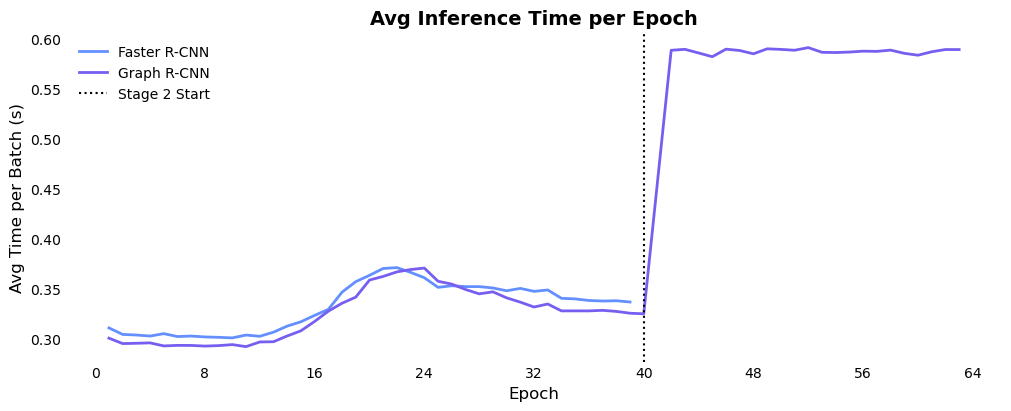

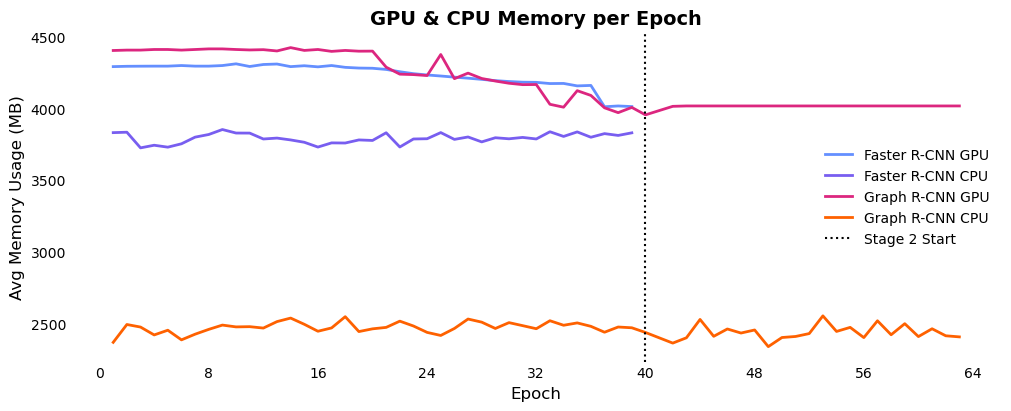

In [30]:
epoch_indices1, times1, gpu1, cpu1 = process_folder_logs_lists("/home/sakr/Thesis/outputs/faster_rcnn/error_faster_rcnn_MobileNet_baseline")
epoch_indices2, _, times2, gpu2, cpu2 = process_dual_epoch_logs("/home/sakr/Thesis/outputs/graph_rcnn/error_graph_rcnn_MobileNet_baseline")


plot_epoch_metrics_comparison(
    epoch_indices1, times1, gpu1, cpu1,
    epoch_indices2, times2, gpu2, cpu2,
    stage2_start_epoch=40 
)

# YOLO

In [32]:
def parse_metrics_table(file_path):
    """
    Parses a log file with metric tables for each epoch in the given format.
    Returns average batch time, average GPU/CPU memory, total energy, total CO2 emissions.
    """
    # Patterns to extract metric values from table lines
    metric_patterns = {
        "Epoch": re.compile(r"\|\s*Epoch\s*\|\s*(\d+)\s*\|"),
        "Avg Batch Time (s)": re.compile(r"\|\s*Avg Batch Time \(s\)\s*\|\s*([\d\.]+)\s*\|"),
        "Max GPU Mem (MB)": re.compile(r"\|\s*Max GPU Mem \(MB\)\s*\|\s*([\d\.]+)\s*\|"),
        "Max CPU Mem (MB)": re.compile(r"\|\s*Max CPU Mem \(MB\)\s*\|\s*([\d\.]+)\s*\|"),
        "Energy (kWh)": re.compile(r"\|\s*Energy \(kWh\)\s*\|\s*([\d\.]+)\s*\|"),
        "CO₂ (kg)": re.compile(r"\|\s*CO₂ \(kg\)\s*\|\s*([\d\.]+)\s*\|"),
    }

    batch_times = []
    gpu_mems = []
    cpu_mems = []
    total_energy = 0.0
    total_co2 = 0.0
    last_valid_co2 = None

    with open(file_path, 'r') as f:
        content = f.read()

    # Split the content by the table separator
    blocks = content.split("+--------------------+---------+")

    for block in blocks:
        # Skip empty or irrelevant blocks
        if not block.strip():
            continue

        # Search and collect metrics in the block
        epoch_found = metric_patterns["Epoch"].search(block)
        if not epoch_found:
            continue  # Skip blocks without an epoch number

        batch_time_match = metric_patterns["Avg Batch Time (s)"].search(block)
        gpu_mem_match = metric_patterns["Max GPU Mem (MB)"].search(block)
        cpu_mem_match = metric_patterns["Max CPU Mem (MB)"].search(block)
        energy_match = metric_patterns["Energy (kWh)"].search(block)
        co2_match = metric_patterns["CO₂ (kg)"].search(block)

        if batch_time_match:
            batch_times.append(float(batch_time_match.group(1)))
        if gpu_mem_match:
            gpu_mems.append(float(gpu_mem_match.group(1)))
        if cpu_mem_match:
            cpu_mems.append(float(cpu_mem_match.group(1)))
        if energy_match:
            total_energy += float(energy_match.group(1))

        if co2_match:
            co2_str = co2_match.group(1)
            # Handle zero or missing CO2 by reusing last valid
            if co2_str == "0.000" and last_valid_co2 is not None:
                co2_val = last_valid_co2
            else:
                co2_val = float(co2_str)
                last_valid_co2 = co2_val
            total_co2 += co2_val

    avg_batch_time = sum(batch_times) / len(batch_times) if batch_times else 0
    avg_gpu_mem = sum(gpu_mems) / len(gpu_mems) if gpu_mems else 0
    avg_cpu_mem = sum(cpu_mems) / len(cpu_mems) if cpu_mems else 0

    return {
        "Average Batch Time (sec)": avg_batch_time,
        "Average GPU Memory Usage (MB)": avg_gpu_mem,
        "Average CPU Memory Usage (MB)": avg_cpu_mem,
        "Total Energy Consumption (kWh)": total_energy,
        "Total CO2 Emissions (kg)": total_co2
    }

def parse_epoch_times(file_path):
    """
    Parses elapsed times only when progress reaches 359/359.
    Returns average elapsed time in seconds and formatted mm:ss.ss string.
    """
    elapsed_times = []

    # Regex to capture elapsed time in [mm:ss<...]
    elapsed_time_pattern = re.compile(r"\[(\d+):(\d+)<")

    with open(file_path, 'r') as f:
        for line in f:
            if "359/359" in line:
                match = elapsed_time_pattern.search(line)
                if match:
                    minutes = int(match.group(1))
                    seconds = int(match.group(2))
                    total_seconds = minutes * 60 + seconds
                    elapsed_times.append(total_seconds)

    if not elapsed_times:
        return 0, "00:00.00"

    avg_elapsed_seconds = sum(elapsed_times) / len(elapsed_times)
    avg_minutes = int(avg_elapsed_seconds // 60)
    avg_seconds = avg_elapsed_seconds % 60

    return avg_elapsed_seconds, f"{avg_minutes:02d}:{avg_seconds:05.2f}"

results = parse_metrics_table("/home/sakr/Thesis/outputs/yolo/output_yolo_baseline")
avg_seconds, avg_mmss = parse_epoch_times("/home/sakr/Thesis/outputs/yolo/error_yolo_baseline")
print(f"Average Epoch Time: {avg_seconds:.2f} seconds ({avg_mmss})")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

Average Epoch Time: 325.92 seconds (05:25.92)
Average Batch Time (sec): 0.6672
Average GPU Memory Usage (MB): 8499.8351
Average CPU Memory Usage (MB): 9146.6676
Total Energy Consumption (kWh): 0.8953
Total CO2 Emissions (kg): 0.2402


In [33]:
def parse_metrics_new_format(file_path):
    # ——— Patterns for YOLO tables ———
    yolo_table_pattern = re.compile(
        r"\+--------------------\+---------\+\n"            # top border
        r"\|\s*Metric\s*\|\s*Value\s*\|\n"                  # header
        r"\+--------------------\+---------\+\n"            # separator
        r"(.*?)"                                            # capture rows
        r"\+--------------------\+---------\+",              # bottom border
        re.DOTALL
    )
    # Within a YOLO table, these keys appear:
    metric_patterns_yolo = {
        "YOLO Epoch":       re.compile(r"\|\s*YOLO Epoch\s*\|\s*(\d+)\s*\|"),
        "Final Loss":       re.compile(r"\|\s*Final Loss\s*\|\s*([\d\.]+)\s*\|"),
        "Avg Batch Time":   re.compile(r"\|\s*Avg Batch Time \(s\)\s*\|\s*([\d\.]+)\s*\|"),
        "Max GPU Mem":      re.compile(r"\|\s*Max GPU Mem \(MB\)\s*\|\s*([\d\.]+)\s*\|"),
        "Max CPU Mem":      re.compile(r"\|\s*Max CPU Mem \(MB\)\s*\|\s*([\d\.]+)\s*\|"),
        "Energy (kWh)":     re.compile(r"\|\s*Energy \(kWh\)\s*\|\s*([\d\.]+)\s*\|"),
        "CO₂ (kg)":         re.compile(r"\|\s*CO₂ \(kg\)\s*\|\s*([\d\.]+)\s*\|"),
    }

    # ——— Patterns for Normal tables ———
    normal_table_pattern = re.compile(
        r"\+-------------------------------\+------------\+\n"      # top border
        r"\|\s*Metric\s*\|\s*Value\s*\|\n"                            # header
        r"\+-------------------------------\+------------\+\n"      # separator
        r"(.*?)"                                                      # capture rows
        r"\+-------------------------------\+------------\+",         # bottom border
        re.DOTALL
    )
    metric_patterns_normal = {
        "Epoch":             re.compile(r"\|\s*Epoch\s*\|\s*(\d+)\s*\|"),
        "Final Loss":        re.compile(r"\|\s*Final Loss\s*\|\s*([\d\.]+)\s*\|"),
        "Avg Batch Time":    re.compile(r"\|\s*Average Batch Time \(sec\)\s*\|\s*([\d\.]+)\s*\|"),
        "Max GPU Mem":       re.compile(r"\|\s*Maximum GPU Memory Usage \(MB\)\s*\|\s*([\d\.]+)\s*\|"),
        "Max CPU Mem":       re.compile(r"\|\s*Maximum CPU Memory Usage \(MB\)\s*\|\s*([\d\.]+)\s*\|"),
        "Energy (kWh)":      re.compile(r"\|\s*Energy Consumption \(kWh\)\s*\|\s*([\d\.]+)(?:\s*kWh)?\s*\|"),
        "CO₂ (kg)":          re.compile(r"\|\s*CO₂ Emissions \(kg\)\s*\|\s*([\d\.]+)(?:\s*kg)?\s*\|"),
    }

    #— Initialize containers —#
    yolo_data = {
        "epochs": [],
        "final_loss": [],
        "batch_times": [],
        "gpu": [],
        "cpu": [],
        "energy": 0.0,
        "co2": 0.0
    }
    normal_data = {
        "epochs": [],
        "final_loss": [],
        "batch_times": [],
        "gpu": [],
        "cpu": [],
        "energy": 0.0,
        "co2": 0.0
    }

    with open(file_path, 'r') as f:
        content = f.read()

    # ——— Extract YOLO tables ———
    for table_body in yolo_table_pattern.findall(content):
        # “table_body” is the chunk of text between the top and bottom borders
        # 1) Find YOLO Epoch number
        m = metric_patterns_yolo["YOLO Epoch"].search(table_body)
        if not m:
            continue
        epoch_num = int(m.group(1))
        yolo_data["epochs"].append(epoch_num)

        # 2) Extract each metric inside that table
        for key, pat in metric_patterns_yolo.items():
            mm = pat.search(table_body)
            if not mm:
                continue
            val_str = mm.group(1)
            val = float(val_str)
            if key == "Final Loss":
                yolo_data["final_loss"].append(val)
            elif key == "Avg Batch Time":
                yolo_data["batch_times"].append(val)
            elif key == "Max GPU Mem":
                yolo_data["gpu"].append(val)
            elif key == "Max CPU Mem":
                yolo_data["cpu"].append(val)
            elif key == "Energy (kWh)":
                yolo_data["energy"] += val
            elif key == "CO₂ (kg)":
                yolo_data["co2"] += val

    # ——— Extract Normal tables ———
    for table_body in normal_table_pattern.findall(content):
        # “table_body” is the chunk between the normal‐table borders
        m = metric_patterns_normal["Epoch"].search(table_body)
        if not m:
            continue
        epoch_num = int(m.group(1))
        normal_data["epochs"].append(epoch_num)

        for key, pat in metric_patterns_normal.items():
            mm = pat.search(table_body)
            if not mm:
                continue
            val_str = mm.group(1)
            val = float(val_str)
            if key == "Final Loss":
                normal_data["final_loss"].append(val)
            elif key == "Avg Batch Time":
                normal_data["batch_times"].append(val)
            elif key == "Max GPU Mem":
                normal_data["gpu"].append(val)
            elif key == "Max CPU Mem":
                normal_data["cpu"].append(val)
            elif key == "Energy (kWh)":
                normal_data["energy"] += val
            elif key == "CO₂ (kg)":
                normal_data["co2"] += val

    def summarize(data):
        n = len(data["epochs"])
        return {
            "Epochs": n,
            "Average Final Loss": sum(data["final_loss"]) / n if data["final_loss"] else 0.0,
            "Average Batch Time (sec)": sum(data["batch_times"]) / n if data["batch_times"] else 0.0,
            "Average GPU Memory Usage (MB)": sum(data["gpu"]) / n if data["gpu"] else 0.0,
            "Average CPU Memory Usage (MB)": sum(data["cpu"]) / n if data["cpu"] else 0.0,
            "Total Energy Consumption (kWh)": data["energy"],
            "Total CO2 Emissions (kg)": data["co2"],
        }

    return {
        "YOLO": summarize(yolo_data),
        "Normal": summarize(normal_data)
    }


def parse_epoch_times_new(log_file_path):
    # ——— YOLO pattern (unchanged) ———
    yolo_tqdm_pattern = re.compile(
        r"^\s*(\d+)/\d+.*?359/359\s*\[\s*(\d+):(\d+)<", re.MULTILINE
    )

    # ——— FIXED Normal pattern ———
    # Matches e.g. “Epoch 1/50:   … 359/359 [00:10<00:00, …]”
    normal_tqdm_pattern = re.compile(
        r"Epoch\s+(\d+)/\d+:[^\n]*?359/359\s*\[\s*(\d+):(\d+)<", re.MULTILINE
    )

    yolo_last = {}
    normal_last = {}

    current_yolo_epoch = None

    with open(log_file_path, "r") as f:
        for line in f:
            # — YOLO: capture “EpochNum/Total … 359/359 [MM:SS<…]”
            m_yolo = yolo_tqdm_pattern.search(line)
            if m_yolo:
                current_yolo_epoch = int(m_yolo.group(1))
                minutes = int(m_yolo.group(2))
                seconds = int(m_yolo.group(3))
                yolo_last[current_yolo_epoch] = minutes * 60 + seconds
                continue

            # — Normal: capture “Epoch N/…: … 359/359 [MM:SS<…]”
            m_norm = normal_tqdm_pattern.search(line)
            if m_norm:
                epoch_num = int(m_norm.group(1))
                minutes   = int(m_norm.group(2))
                seconds   = int(m_norm.group(3))
                normal_last[epoch_num] = minutes * 60 + seconds

    def average_and_format(dct):
        if not dct:
            return 0.0, "00:00.00"
        vals = list(dct.values())
        avg = sum(vals) / len(vals)
        mm = int(avg // 60)
        ss = avg % 60
        return avg, f"{mm:02d}:{ss:05.2f}"

    yolo_avg_s,   yolo_fmt   = average_and_format(yolo_last)
    normal_avg_s, normal_fmt = average_and_format(normal_last)

    return {
        "YOLO":   (yolo_avg_s,   yolo_fmt),
        "Normal": (normal_avg_s, normal_fmt)
    }


metrics_file = "/home/sakr/Thesis/outputs/yolo/output_yolo_gnn_baseline"
log_file = "/home/sakr/Thesis/outputs/yolo/error_yolo_gnn_baseline"

metrics_results = parse_metrics_new_format(metrics_file)
epoch_times_results = parse_epoch_times_new(log_file)

for section in ["YOLO", "Normal"]:
    print(f"--- {section} Metrics ---")
    for metric, value in metrics_results[section].items():
        if isinstance(value, float):
            print(f"{metric}: {value:.4f}")
        else:
            print(f"{metric}: {value}")
    avg_sec, avg_fmt = epoch_times_results[section]
    print(f"Average Epoch Time: {avg_sec:.2f} seconds ({avg_fmt})\n")


--- YOLO Metrics ---
Epochs: 29
Average Final Loss: 64.9357
Average Batch Time (sec): 0.6577
Average GPU Memory Usage (MB): 8471.6655
Average CPU Memory Usage (MB): 6249.5690
Total Energy Consumption (kWh): 0.6485
Total CO2 Emissions (kg): 0.1739
Average Epoch Time: 321.17 seconds (05:21.17)

--- Normal Metrics ---
Epochs: 25
Average Final Loss: 0.3476
Average Batch Time (sec): 0.2577
Average GPU Memory Usage (MB): 4176.9300
Average CPU Memory Usage (MB): 2974.8940
Total Energy Consumption (kWh): 0.3522
Total CO2 Emissions (kg): 0.0943
Average Epoch Time: 264.77 seconds (04:24.77)



=== Model 1 (YOLO‐only) Summary ===
Average Epoch Time: 325.92s (05:25.92)
Epoch  0: time=0.6794s, GPU=8118.7MB, CPU=7107.5MB
Epoch  1: time=0.6706s, GPU=8128.7MB, CPU=7433.4MB
Epoch  2: time=0.6671s, GPU=8832.7MB, CPU=7881.8MB
Epoch  3: time=0.6665s, GPU=8832.7MB, CPU=8159.0MB
Epoch  4: time=0.6670s, GPU=8868.7MB, CPU=8273.8MB
Epoch  5: time=0.6661s, GPU=8846.7MB, CPU=8300.9MB
Epoch  6: time=0.6666s, GPU=8870.7MB, CPU=8446.9MB
Epoch  7: time=0.6668s, GPU=8336.7MB, CPU=8763.8MB
Epoch  8: time=0.6661s, GPU=8414.7MB, CPU=8677.3MB
Epoch  9: time=0.6670s, GPU=8438.7MB, CPU=9069.6MB
Epoch 10: time=0.6671s, GPU=8766.7MB, CPU=9004.7MB
Epoch 11: time=0.6666s, GPU=8802.7MB, CPU=9361.2MB
Epoch 12: time=0.6662s, GPU=8380.7MB, CPU=9280.1MB
Epoch 13: time=0.6663s, GPU=8406.7MB, CPU=9532.8MB
Epoch 14: time=0.6670s, GPU=8326.7MB, CPU=9436.8MB
Epoch 15: time=0.6663s, GPU=8410.7MB, CPU=9529.1MB
Epoch 16: time=0.6666s, GPU=8410.7MB, CPU=9431.2MB
Epoch 17: time=0.6667s, GPU=8436.7MB, CPU=9569.4MB
Epoch 1

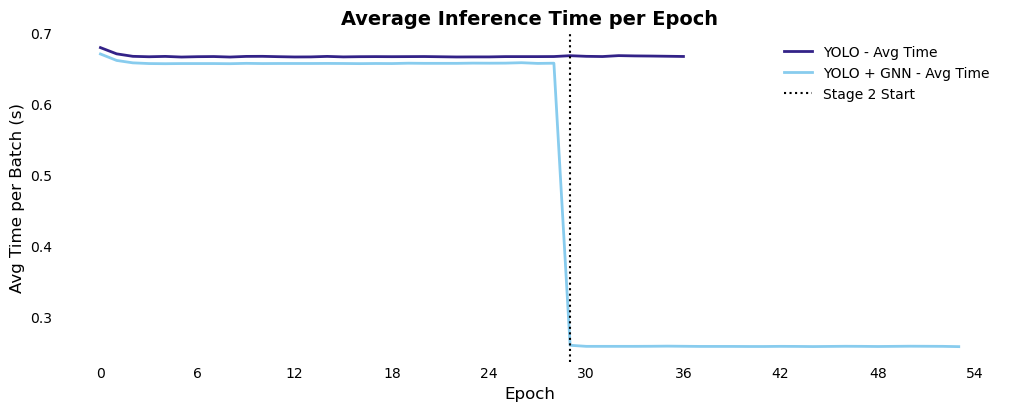

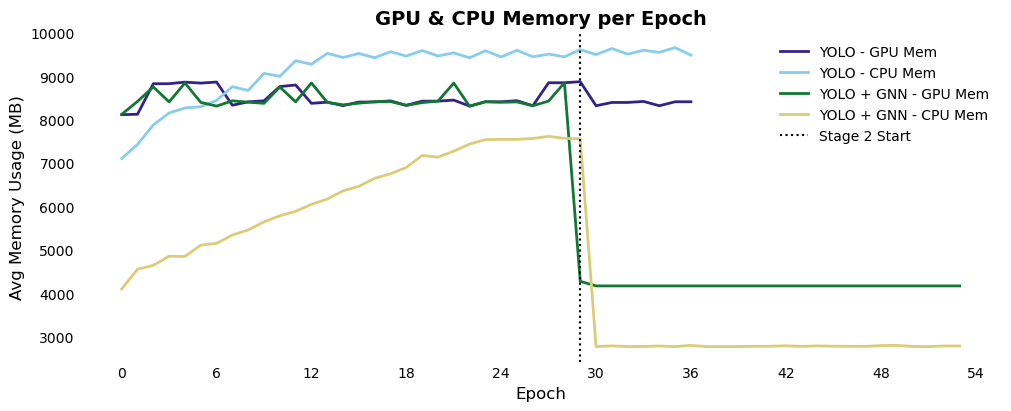

In [34]:
def parse_metrics_table_per_epoch(file_path):
    """
    Parses a YOLO‐only metrics file where each epoch’s metrics appear in a box like:

      +--------------------+---------+
      |       Metric       |  Value  |
      +--------------------+---------+
      |       Epoch        |    0    |
      |     Final Loss     | 69.0220 |
      | Avg Batch Time (s) | 0.6794  |
      |  Max GPU Mem (MB)  | 8118.7  |
      |  Max CPU Mem (MB)  | 7107.5  |
      |    Energy (kWh)    | 0.0243  |
      |      CO₂ (kg)      | 0.0065  |
      +--------------------+---------+

    Returns:
      epochs, batch_times, gpu_mems, cpu_mems, total_energy, total_co2
    """
    epoch_pat        = re.compile(r"\|\s*Epoch\s*\|\s*(\d+)\s*\|")
    batch_time_pat   = re.compile(r"\|\s*Avg Batch Time\s*\(s\)\s*\|\s*([\d\.]+)\s*\|")
    gpu_mem_pat      = re.compile(r"\|\s*Max GPU Mem\s*\(MB\)\s*\|\s*([\d\.]+)\s*\|")
    cpu_mem_pat      = re.compile(r"\|\s*Max CPU Mem\s*\(MB\)\s*\|\s*([\d\.]+)\s*\|")
    energy_pat       = re.compile(r"\|\s*Energy\s*\(kWh\)\s*\|\s*([\d\.]+)\s*\|")
    co2_pat          = re.compile(r"\|\s*CO₂\s*\(kg\)\s*\|\s*([\d\.]+)\s*\|")

    epochs      = []
    batch_times = []
    gpu_mems    = []
    cpu_mems    = []
    total_energy = 0.0
    total_co2    = 0.0
    last_valid_co2 = None

    with open(file_path, "r") as f:
        content = f.read()

    blocks = content.split("+--------------------+---------+")
    for block in blocks:
        block = block.strip()
        if not block:
            continue

        m_ep = epoch_pat.search(block)
        if not m_ep:
            continue

        ep = int(m_ep.group(1))
        epochs.append(ep)

        m_bt = batch_time_pat.search(block)
        m_gm = gpu_mem_pat.search(block)
        m_cm = cpu_mem_pat.search(block)
        m_en = energy_pat.search(block)
        m_co = co2_pat.search(block)

        batch_times.append(float(m_bt.group(1)) if m_bt else 0.0)
        gpu_mems.append(float(m_gm.group(1))      if m_gm else 0.0)
        cpu_mems.append(float(m_cm.group(1))      if m_cm else 0.0)

        if m_en:
            total_energy += float(m_en.group(1))

        if m_co:
            co2_str = m_co.group(1)
            if co2_str == "0.000" and last_valid_co2 is not None:
                co2_val = last_valid_co2
            else:
                co2_val = float(co2_str)
                last_valid_co2 = co2_val
            total_co2 += co2_val

    return epochs, batch_times, gpu_mems, cpu_mems, total_energy, total_co2


def parse_epoch_times(file_path):
    """
    Parses only the lines where training reached “359/359” and extracts elapsed [mm:ss<…].
    Returns (avg_seconds, "MM:SS.ss").
    """
    elapsed_times = []
    elapsed_time_pat = re.compile(r"\[(\d+):(\d+)<")

    with open(file_path, "r") as f:
        for line in f:
            if "359/359" not in line:
                continue
            m = elapsed_time_pat.search(line)
            if m:
                minutes = int(m.group(1))
                seconds = int(m.group(2))
                elapsed_times.append(minutes * 60 + seconds)

    if not elapsed_times:
        return 0.0, "00:00.00"

    avg = sum(elapsed_times) / len(elapsed_times)
    mm = int(avg // 60)
    ss = avg % 60
    return avg, f"{mm:02d}:{ss:05.2f}"


# === Parser for Model 2 (YOLO + Normal) ===
def parse_metrics_yolo_then_normal_per_epoch(file_path):
    """
    Parses a combined file that first contains YOLO‐tables, then Normal‐tables.
    Returns two tuples:
      (yolo_epochs, yolo_times, yolo_gpu, yolo_cpu),
      (norm_epochs, norm_times, norm_gpu, norm_cpu)
    """
    # — YOLO tables — 
    yolo_table_pat = re.compile(
        r"\+--------------------\+---------\+\n"
        r"\|\s*Metric\s*\|\s*Value\s*\|\n"
        r"\+--------------------\+---------\+\n"
        r"(.*?)"
        r"\+--------------------\+---------\+",
        re.DOTALL
    )
    metric_pat_yolo = {
        "YOLO Epoch":     re.compile(r"\|\s*YOLO Epoch\s*\|\s*(\d+)\s*\|"),
        "Avg Batch Time": re.compile(r"\|\s*Avg Batch Time\s*\(s\)\s*\|\s*([\d\.]+)\s*\|"),
        "Max GPU Mem":    re.compile(r"\|\s*Max GPU Mem\s*\(MB\)\s*\|\s*([\d\.]+)\s*\|"),
        "Max CPU Mem":    re.compile(r"\|\s*Max CPU Mem\s*\(MB\)\s*\|\s*([\d\.]+)\s*\|"),
    }

    # — Normal tables —
    normal_table_pat = re.compile(
        r"\+-------------------------------\+------------\+\n"
        r"\|\s*Metric\s*\|\s*Value\s*\|\n"
        r"\+-------------------------------\+------------\+\n"
        r"(.*?)"
        r"\+-------------------------------\+------------\+",
        re.DOTALL
    )
    metric_pat_norm = {
        "Epoch":             re.compile(r"\|\s*Epoch\s*\|\s*(\d+)\s*\|"),
        "Avg Batch Time":    re.compile(r"\|\s*Average Batch Time\s*\(sec\)\s*\|\s*([\d\.]+)\s*\|"),
        "Max GPU Mem":       re.compile(r"\|\s*Maximum GPU Memory Usage\s*\(MB\)\s*\|\s*([\d\.]+)\s*\|"),
        "Max CPU Mem":       re.compile(r"\|\s*Maximum CPU Memory Usage\s*\(MB\)\s*\|\s*([\d\.]+)\s*\|"),
    }

    yolo_epochs = []
    yolo_times  = []
    yolo_gpu    = []
    yolo_cpu    = []

    norm_epochs = []
    norm_times  = []
    norm_gpu    = []
    norm_cpu    = []

    with open(file_path, "r") as f:
        content = f.read()

    # Extract YOLO tables
    for body in yolo_table_pat.findall(content):
        m_ep  = metric_pat_yolo["YOLO Epoch"].search(body)
        m_bt  = metric_pat_yolo["Avg Batch Time"].search(body)
        m_gpu = metric_pat_yolo["Max GPU Mem"].search(body)
        m_cpu = metric_pat_yolo["Max CPU Mem"].search(body)

        if not (m_ep and m_bt and m_gpu and m_cpu):
            continue

        e = int(m_ep.group(1))
        yolo_epochs.append(e)
        yolo_times.append(float(m_bt.group(1)))
        yolo_gpu.append(float(m_gpu.group(1)))
        yolo_cpu.append(float(m_cpu.group(1)))

    # Extract Normal tables
    for body in normal_table_pat.findall(content):
        m_ep  = metric_pat_norm["Epoch"].search(body)
        m_bt  = metric_pat_norm["Avg Batch Time"].search(body)
        m_gpu = metric_pat_norm["Max GPU Mem"].search(body)
        m_cpu = metric_pat_norm["Max CPU Mem"].search(body)

        if not (m_ep and m_bt and m_gpu and m_cpu):
            continue

        e = int(m_ep.group(1))
        norm_epochs.append(e)
        norm_times.append(float(m_bt.group(1)))
        norm_gpu.append(float(m_gpu.group(1)))
        norm_cpu.append(float(m_cpu.group(1)))

    return (yolo_epochs, yolo_times, yolo_gpu, yolo_cpu), \
           (norm_epochs, norm_times, norm_gpu, norm_cpu)


def parse_epoch_times_new(log_file_path):
    """
    Parses a combined error/log file to extract:
      • For YOLO portion: lines like " 29/50 … 359/359 [MM:SS<…]" → record (epoch→seconds)
      • For Normal portion: lines like "Epoch  1/50: … 359/359 [MM:SS<…]" → record (epoch→seconds)

    Returns:
      { "YOLO": (avg_s, "MM:SS.ss"), "Normal": (avg_s, "MM:SS.ss") }
    """
    yolo_tqdm_pat = re.compile(r"^\s*(\d+)/\d+.*?359/359\s*\[\s*(\d+):(\d+)<", re.MULTILINE)
    norm_tqdm_pat = re.compile(r"Epoch\s+(\d+)/\d+:[^\n]*?359/359\s*\[\s*(\d+):(\d+)<", re.MULTILINE)

    yolo_last   = {}
    normal_last = {}

    with open(log_file_path, "r") as f:
        for line in f:
            m_y = yolo_tqdm_pat.search(line)
            if m_y:
                ep = int(m_y.group(1))
                mm = int(m_y.group(2))
                ss = int(m_y.group(3))
                yolo_last[ep] = mm * 60 + ss
                continue

            m_n = norm_tqdm_pat.search(line)
            if m_n:
                ep = int(m_n.group(1))
                mm = int(m_n.group(2))
                ss = int(m_n.group(3))
                normal_last[ep] = mm * 60 + ss

    def average_and_format(d):
        if not d:
            return 0.0, "00:00.00"
        vals = list(d.values())
        avg = sum(vals) / len(vals)
        m = int(avg // 60)
        s = avg % 60
        return avg, f"{m:02d}:{s:05.2f}"

    y_avg, y_fmt = average_and_format(yolo_last)
    n_avg, n_fmt = average_and_format(normal_last)
    return { "YOLO": (y_avg, y_fmt), "Normal": (n_avg, n_fmt) }


# === Plotting function (shared by both models) ===
def plot_epoch_metrics_comparison(
    epoch_indices1, avg_times1, avg_gpu1, avg_cpu1,
    epoch_indices2, avg_times2, avg_gpu2, avg_cpu2,
    stage2_start_epoch
):
    # --- Prepare data ---
    all_epochs = sorted(set(epoch_indices1 + epoch_indices2))

    def build_dict(keys, values):
        return dict(zip(keys, values))

    def align(epoch_list, metrics_dict):
        return [metrics_dict.get(e, np.nan) for e in epoch_list]

    t1 = align(all_epochs, build_dict(epoch_indices1, avg_times1))
    t2 = align(all_epochs, build_dict(epoch_indices2, avg_times2))
    g1 = align(all_epochs, build_dict(epoch_indices1, avg_gpu1))
    c1 = align(all_epochs, build_dict(epoch_indices1, avg_cpu1))
    g2 = align(all_epochs, build_dict(epoch_indices2, avg_gpu2))
    c2 = align(all_epochs, build_dict(epoch_indices2, avg_cpu2))

    # --- Style settings ---
    tufte_font = {'fontsize': 12}
    title_font = {'fontsize': 14, 'weight': 'bold'}
    line_width = 2.0

    # Color-blind friendly palette (Paul Tol’s medium contrast)
    colors = ['#332288', '#88CCEE', '#117733', '#DDCC77', '#CC6677']

    def simplify_axes(ax):
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(axis='both', which='both', length=0)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        ax.grid(False)

    # --- Plot 1: Avg Inference Time per Epoch ---
    fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

    ax.plot(all_epochs, t1, label="YOLO - Avg Time", color=colors[0], linewidth=line_width)
    ax.plot(all_epochs, t2, label="YOLO + GNN - Avg Time", color=colors[1], linewidth=line_width)
    ax.axvline(stage2_start_epoch, linestyle=':', color='#000000', linewidth=1.5, label="Stage 2 Start")

    ax.set_title("Average Inference Time per Epoch", **title_font)
    ax.set_xlabel("Epoch", **tufte_font)
    ax.set_ylabel("Avg Time per Batch (s)", **tufte_font)
    ax.legend(frameon=False, fontsize=10)
    simplify_axes(ax)
    plt.show()

    # --- Plot 2: GPU & CPU Memory per Epoch ---
    fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

    ax.plot(all_epochs, g1, label="YOLO - GPU Mem", color=colors[0], linewidth=line_width)
    ax.plot(all_epochs, c1, label="YOLO - CPU Mem", color=colors[1], linewidth=line_width)
    ax.plot(all_epochs, g2, label="YOLO + GNN - GPU Mem", color=colors[2], linewidth=line_width)
    ax.plot(all_epochs, c2, label="YOLO + GNN - CPU Mem", color=colors[3], linewidth=line_width)
    ax.axvline(stage2_start_epoch, linestyle=':', color='#000000', linewidth=1.5, label="Stage 2 Start")

    ax.set_title("GPU & CPU Memory per Epoch", **title_font)
    ax.set_xlabel("Epoch", **tufte_font)
    ax.set_ylabel("Avg Memory Usage (MB)", **tufte_font)
    ax.legend(frameon=False, fontsize=10)
    simplify_axes(ax)
    plt.show()



file1_metrics = "/home/sakr/Thesis/outputs/yolo/output_yolo_baseline"
file1_log     = "/home/sakr/Thesis/outputs/yolo/error_yolo_baseline"

# Paths for Model 2 (YOLO + Normal)
file2_metrics = "/home/sakr/Thesis/outputs/yolo/output_yolo_gnn_baseline"
file2_log     = "/home/sakr/Thesis/outputs/yolo/error_yolo_gnn_baseline"


epochs1, times1, gpu1, cpu1, total_en1, total_co21 = \
    parse_metrics_table_per_epoch(file1_metrics)
avg_sec1, fmt1 = parse_epoch_times(file1_log)

print("=== Model 1 (YOLO‐only) Summary ===")
print(f"Average Epoch Time: {avg_sec1:.2f}s ({fmt1})")
for ep, t, g, c in zip(epochs1, times1, gpu1, cpu1):
    print(f"Epoch {ep:2d}: time={t:.4f}s, GPU={g:.1f}MB, CPU={c:.1f}MB")
print(f"Total Energy: {total_en1:.4f} kWh, Total CO₂: {total_co21:.4f} kg\n")

# ---- Parse Model 2 ----
(yolo_eps2, yolo_t2, yolo_g2, yolo_c2), \
(norm_eps2, norm_t2, norm_g2, norm_c2) = \
    parse_metrics_yolo_then_normal_per_epoch(file2_metrics)

epoch_times2 = parse_epoch_times_new(file2_log)
print("=== Model 2 (YOLO+Normal) Summary ===")
print(f"YOLO‐stage average epoch time: {epoch_times2['YOLO'][0]:.2f}s ({epoch_times2['YOLO'][1]})")
print(f"Normal‐stage average epoch time: {epoch_times2['Normal'][0]:.2f}s ({epoch_times2['Normal'][1]})\n")

# Combine Model 2 epochs so that Normal epochs follow immediately after YOLO epochs
max_yolo2 = max(yolo_eps2) if yolo_eps2 else 0
epoch_indices2 = []
avg_times2    = []
avg_gpu2      = []
avg_cpu2      = []

# Append YOLO epochs as‐is
for e, t, g, c in zip(yolo_eps2, yolo_t2, yolo_g2, yolo_c2):
    epoch_indices2.append(e)
    avg_times2.append(t)
    avg_gpu2.append(g)
    avg_cpu2.append(c)

# Append Normal epochs, shifted by max_yolo2
for ne, nt, ng, nc in zip(norm_eps2, norm_t2, norm_g2, norm_c2):
    combined_e = max_yolo2 + ne
    epoch_indices2.append(combined_e)
    avg_times2.append(nt)
    avg_gpu2.append(ng)
    avg_cpu2.append(nc)

# Model 1’s lists:
epoch_indices1 = epochs1
avg_times1     = times1
avg_gpu1       = gpu1
avg_cpu1       = cpu1

# Stage‐2 (Normal) start point for Model 2:
stage2_start_epoch = max_yolo2 + 1

# ---- Plot both models side by side ----
plot_epoch_metrics_comparison(
    epoch_indices1, avg_times1, avg_gpu1, avg_cpu1,
    epoch_indices2, avg_times2, avg_gpu2, avg_cpu2,
    stage2_start_epoch
    )